# Using TensorTrade for Making a Simple Trading Algorithm

Source: https://levelup.gitconnected.com/using-tensortrade-for-making-a-simple-trading-algorithm-6fad4d9bc79c

In this tutorial, I’m going to show how to use Ray with TensorTrade (TT) in order to create a profitable algorithm on a predictable sine curve. You may be asking yourself, why use something so simple when the real world is much more difficult to predict? This is a very good question, and there is a simple answer.

Let’s define two instruments we want to have in our portfolio. We’ll use the U.S. dollar and a fake coin called TensorTrade Coin.

In [1]:
from tensortrade.oms.instruments import Instrument

USD = Instrument("USD", 2, "U.S. Dollar")
TTC = Instrument("TTC", 8, "TensorTrade Coin")

## Define action scheme

Ideally, we expect our agent to sell at the peaks and buy at the troughs. I’ll define actions that will allow us to perform this behavior. The ActionScheme I’ve built is extremely simple, relying on only two internal states: cash and asset.

State Meaning Table

The following is a transition diagram showing the states along with the actions that can be made: stay and move.

Transition Diagram

For example, if I start in cash and choose move, then I’ll transition to asset and receive P(t)-P(t-1) as a reward, where P(t) is the price of the asset at time step t. The rewards ascribed to these arrows will be described in further detail below.

In [2]:
from gym.spaces import Discrete

from tensortrade.env.default.actions import TensorTradeActionScheme

from tensortrade.env.generic import ActionScheme, TradingEnv
from tensortrade.core import Clock
from tensortrade.oms.instruments import ExchangePair
from tensortrade.oms.wallets import Portfolio
from tensortrade.oms.orders import (
    Order,
    proportion_order,
    TradeSide,
    TradeType
)


class BSH(TensorTradeActionScheme):

    registered_name = "bsh"

    def __init__(self, cash: 'Wallet', asset: 'Wallet'):
        super().__init__()
        self.cash = cash
        self.asset = asset

        self.listeners = []
        self.action = 0

    @property
    def action_space(self):
        return Discrete(2)

    def attach(self, listener):
        self.listeners += [listener]
        return self

    def get_orders(self, action: int, portfolio: 'Portfolio'):
        order = None

        if abs(action - self.action) > 0:
            src = self.cash if self.action == 0 else self.asset
            tgt = self.asset if self.action == 0 else self.cash
            order = proportion_order(portfolio, src, tgt, 1.0)
            self.action = action

        for listener in self.listeners:
            listener.on_action(action)

        return [order]

    def reset(self):
        super().reset()
        self.action = 0

## Define reward scheme

Next, I’ll create a reward scheme to reflect how well we are positioned in the environment. Essentially, we want a mapping that reflects the correct reward for each state we are in.

In [3]:
from tensortrade.env.default.rewards import TensorTradeRewardScheme
from tensortrade.feed.core import Stream, DataFeed


class PBR(TensorTradeRewardScheme):

    registered_name = "pbr"

    def __init__(self, price: 'Stream'):
        super().__init__()
        self.position = -1

        r = Stream.sensor(price, lambda p: p.value, dtype="float").diff()
        position = Stream.sensor(self, lambda rs: rs.position, dtype="float")

        reward = (r * position).fillna(0).rename("reward")

        self.feed = DataFeed([reward])
        self.feed.compile()

    def on_action(self, action: int):
        self.position = -1 if action == 0 else 1

    def get_reward(self, portfolio: 'Portfolio'):
        return self.feed.next()["reward"]

    def reset(self):
        self.position = -1
        self.feed.reset()

## Define renderer

Finally, we would like to make sure we can see if the agent is selling at the peaks and buying at the troughs. Here is a Renderer that can display this information using Matplotlib.

In [4]:
import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer


class PositionChangeChart(Renderer):

    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")
        
#         env.action_scheme.portfolio.performance.plot(ax=axs[1])
        performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
        columns = [1,2,4,5,7]
        performance.drop(performance.columns[columns],axis=1,inplace=True)
        performance.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

## Train the agent

Frist, in order to use our custom environment in ray, we must write a function that creates an instance of the TradingEnv from a configuration dictionary.

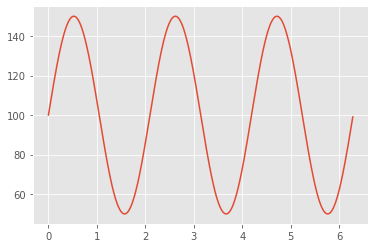

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
x = np.arange(0, 2*np.pi, 2*np.pi / 1001)
y = 50*np.sin(3*x) + 100

plt.plot(x,y)

In [6]:
import ray
import numpy as np
import pandas as pd

from ray import tune
from ray.tune.registry import register_env

import tensortrade.env.default as default

from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio

def create_env(config):
    x = np.arange(0, 2*np.pi, 2*np.pi / 1001)
    y = 50*np.sin(3*x) + 100

    x = np.arange(0, 2*np.pi, 2*np.pi / 1000)
    p = Stream.source(y, dtype="float").rename("USD-TTC")

    bitfinex = Exchange("bitfinex", service=execute_order)(
        p
    )

    cash = Wallet(bitfinex, 100000 * USD)
    asset = Wallet(bitfinex, 0 * TTC)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])

    feed = DataFeed([
        p,
        p.rolling(window=10).mean().rename("fast"),
        p.rolling(window=50).mean().rename("medium"),
        p.rolling(window=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(y, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.2
    )
    return environment

register_env("TradingEnv", create_env)

Next, since the environment is registered, we can use the Proximal Policy Optimization (PPO) algorithm from rllib to train our agent.

To check if everything works, set a low episode_reward_mean so a fast check can be done (set at 10). Once everything is working, set it to 3000 and run the training. Once the training is complete, we can get access to the agent’s policy by restoring from the last checkpoint.

In [7]:
analysis = tune.run(
    "PPO",
    stop={
      "episode_reward_mean": 500
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25
        },
#         "log_level": "DEBUG",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 2,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True
)

2021-05-08 18:36:35,068	INFO resource_spec.py:223 -- Starting Ray with 2.29 GiB memory available for workers and up to 1.16 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-05-08 18:36:35,666	INFO services.py:1191 -- View the Ray dashboard at localhost:8265


Trial name,status,loc
PPO_TradingEnv_ffe35_00000,RUNNING,


(pid=4015) WARNING:tensorflow:From /Users/yuan/Projects/github/ai-trading/env/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=4015) Instructions for updating:
(pid=4015) non-resource variables are not supported in the long term
(pid=4015) 2021-05-08 18:36:51,688	INFO trainer.py:630 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=4015) 2021-05-08 18:36:51,812	WARNING util.py:37 -- Install gputil for GPU system monitoring.
(pid=4013) WARNING:tensorflow:From /Users/yuan/Projects/github/ai-trading/env/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=4013) Instructions for updating:
(pid=4013) non-resource variables are 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_ffe35_00000,RUNNING,192.168.0.249:4015,1,39.6869,4000,18.3682


Result for PPO_TradingEnv_ffe35_00000:
  custom_metrics: {}
  date: 2021-05-08_18-37-52
  done: false
  episode_len_mean: 961.25
  episode_reward_max: 226.70565024647192
  episode_reward_mean: 106.39808501504442
  episode_reward_min: -1.2461229763878379
  episodes_this_iter: 4
  episodes_total: 8
  experiment_id: 981378969b494c0ba4f5a4a8ac24053d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.30000000000000004
        cur_lr: 0.0007000000000000001
        entropy: 0.3838173961266875
        entropy_coeff: 0.01
        kl: 0.12823779159225523
        policy_loss: -0.25967317284084857
        total_loss: 0.228951912780758
        vf_explained_var: 0.005409572273492813
        vf_loss: 0.9079838395118713
    num_steps_sampled: 8000
    num_steps_trained: 8000
  iterations_since_restore: 2
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_ut

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_ffe35_00000,RUNNING,192.168.0.249:4015,2,60.7652,8000,106.398


Result for PPO_TradingEnv_ffe35_00000:
  custom_metrics: {}
  date: 2021-05-08_18-38-15
  done: false
  episode_len_mean: 974.1666666666666
  episode_reward_max: 469.17361370254383
  episode_reward_mean: 217.95150156304746
  episode_reward_min: -1.2461229763878379
  episodes_this_iter: 4
  episodes_total: 12
  experiment_id: 981378969b494c0ba4f5a4a8ac24053d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.45000000000000007
        cur_lr: 0.00030000000000000003
        entropy: 0.2445016661658883
        entropy_coeff: 0.01
        kl: 0.028992961801122874
        policy_loss: -0.12704828489222564
        total_loss: 0.14678693082532845
        vf_explained_var: 0.023395508527755737
        vf_loss: 0.5264667961746454
    num_steps_sampled: 12000
    num_steps_trained: 12000
  iterations_since_restore: 3
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_ffe35_00000,RUNNING,192.168.0.249:4015,3,83.2273,12000,217.952


Result for PPO_TradingEnv_ffe35_00000:
  custom_metrics: {}
  date: 2021-05-08_18-38-37
  done: false
  episode_len_mean: 980.625
  episode_reward_max: 534.1838006505275
  episode_reward_mean: 294.8747739171613
  episode_reward_min: -1.2461229763878379
  episodes_this_iter: 4
  episodes_total: 16
  experiment_id: 981378969b494c0ba4f5a4a8ac24053d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.675
        cur_lr: 9.800000000000001e-05
        entropy: 0.17006590543314815
        entropy_coeff: 0.01
        kl: 0.009522290085442364
        policy_loss: -0.08008196551236324
        total_loss: 0.07092036912217736
        vf_explained_var: 0.0377044677734375
        vf_loss: 0.2925508935004473
    num_steps_sampled: 16000
    num_steps_trained: 16000
  iterations_since_restore: 4
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_ffe35_00000,RUNNING,192.168.0.249:4015,4,105.768,16000,294.875


Result for PPO_TradingEnv_ffe35_00000:
  custom_metrics: {}
  date: 2021-05-08_18-39-00
  done: false
  episode_len_mean: 984.5
  episode_reward_max: 572.7311384575032
  episode_reward_mean: 348.04357227314733
  episode_reward_min: -1.2461229763878379
  episodes_this_iter: 4
  episodes_total: 20
  experiment_id: 981378969b494c0ba4f5a4a8ac24053d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.675
        cur_lr: 9.400000000000001e-05
        entropy: 0.11763733252882957
        entropy_coeff: 0.01
        kl: 0.005205405308515765
        policy_loss: -0.06562070676591247
        total_loss: 0.032421068142866716
        vf_explained_var: -0.003954309970140457
        vf_loss: 0.19140900019556284
    num_steps_sampled: 20000
    num_steps_trained: 20000
  iterations_since_restore: 5
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_per

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_ffe35_00000,RUNNING,192.168.0.249:4015,5,128.107,20000,348.044


Result for PPO_TradingEnv_ffe35_00000:
  custom_metrics: {}
  date: 2021-05-08_18-39-21
  done: false
  episode_len_mean: 987.0833333333334
  episode_reward_max: 583.6174672199518
  episode_reward_mean: 385.53731221208346
  episode_reward_min: -1.2461229763878379
  episodes_this_iter: 4
  episodes_total: 24
  experiment_id: 981378969b494c0ba4f5a4a8ac24053d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.675
        cur_lr: 9.0e-05
        entropy: 0.0754160899668932
        entropy_coeff: 0.01
        kl: 0.004719858232419938
        policy_loss: -0.048743662890046835
        total_loss: 0.024093242536764592
        vf_explained_var: 0.03690539300441742
        vf_loss: 0.14081032038666308
    num_steps_sampled: 24000
    num_steps_trained: 24000
  iterations_since_restore: 6
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_ffe35_00000,RUNNING,192.168.0.249:4015,6,149.108,24000,385.537


Result for PPO_TradingEnv_ffe35_00000:
  custom_metrics: {}
  date: 2021-05-08_18-39-46
  done: false
  episode_len_mean: 988.9285714285714
  episode_reward_max: 590.428623065467
  episode_reward_mean: 414.50834190999416
  episode_reward_min: -1.2461229763878379
  episodes_this_iter: 4
  episodes_total: 28
  experiment_id: 981378969b494c0ba4f5a4a8ac24053d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.3375
        cur_lr: 8.6e-05
        entropy: 0.04107798699988052
        entropy_coeff: 0.01
        kl: 0.004930793642415665
        policy_loss: -0.035555259499233216
        total_loss: 0.009744309383677319
        vf_explained_var: -0.029857104644179344
        vf_loss: 0.0880924147204496
    num_steps_sampled: 28000
    num_steps_trained: 28000
  iterations_since_restore: 7
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_perce

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_ffe35_00000,RUNNING,192.168.0.249:4015,7,174.32,28000,414.508


Result for PPO_TradingEnv_ffe35_00000:
  custom_metrics: {}
  date: 2021-05-08_18-40-10
  done: false
  episode_len_mean: 990.3125
  episode_reward_max: 594.8076937074848
  episode_reward_mean: 436.71773702810464
  episode_reward_min: -1.2461229763878379
  episodes_this_iter: 4
  episodes_total: 32
  experiment_id: 981378969b494c0ba4f5a4a8ac24053d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.16875
        cur_lr: 8.2e-05
        entropy: 0.02443950329325162
        entropy_coeff: 0.01
        kl: 0.002410511351627065
        policy_loss: -0.02945681006531231
        total_loss: -0.0017231754609383643
        vf_explained_var: -0.05481066182255745
        vf_loss: 0.055142514800536446
    num_steps_sampled: 32000
    num_steps_trained: 32000
  iterations_since_restore: 8
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 6

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_ffe35_00000,RUNNING,192.168.0.249:4015,8,198.167,32000,436.718


Result for PPO_TradingEnv_ffe35_00000:
  custom_metrics: {}
  date: 2021-05-08_18-40-32
  done: false
  episode_len_mean: 991.3888888888889
  episode_reward_max: 597.6919531098597
  episode_reward_mean: 454.51857795934444
  episode_reward_min: -1.2461229763878379
  episodes_this_iter: 4
  episodes_total: 36
  experiment_id: 981378969b494c0ba4f5a4a8ac24053d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.084375
        cur_lr: 7.8e-05
        entropy: 0.017236730695003644
        entropy_coeff: 0.01
        kl: 0.0010040743027275312
        policy_loss: -0.016784665756858885
        total_loss: -0.0014080391556490213
        vf_explained_var: -0.31303301453590393
        vf_loss: 0.030928549203963485
    num_steps_sampled: 36000
    num_steps_trained: 36000
  iterations_since_restore: 9
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_ut

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_ffe35_00000,RUNNING,192.168.0.249:4015,9,220.71,36000,454.519


Result for PPO_TradingEnv_ffe35_00000:
  custom_metrics: {}
  date: 2021-05-08_18-40-56
  done: false
  episode_len_mean: 992.25
  episode_reward_max: 597.6919531098597
  episode_reward_mean: 468.77544176926403
  episode_reward_min: -1.2461229763878379
  episodes_this_iter: 4
  episodes_total: 40
  experiment_id: 981378969b494c0ba4f5a4a8ac24053d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.0421875
        cur_lr: 7.400000000000001e-05
        entropy: 0.01255662623225362
        entropy_coeff: 0.01
        kl: 0.0005368198526412016
        policy_loss: -0.018688138166908175
        total_loss: -0.0038250793877523392
        vf_explained_var: -0.14291024208068848
        vf_loss: 0.029931954537460115
    num_steps_sampled: 40000
    num_steps_trained: 40000
  iterations_since_restore: 10
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cp

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_ffe35_00000,RUNNING,192.168.0.249:4015,10,244.682,40000,468.775


Result for PPO_TradingEnv_ffe35_00000:
  custom_metrics: {}
  date: 2021-05-08_18-41-17
  done: false
  episode_len_mean: 992.9545454545455
  episode_reward_max: 598.019796302425
  episode_reward_mean: 480.515596471842
  episode_reward_min: -1.2461229763878379
  episodes_this_iter: 4
  episodes_total: 44
  experiment_id: 981378969b494c0ba4f5a4a8ac24053d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.02109375
        cur_lr: 7.000000000000001e-05
        entropy: 0.010373034750955412
        entropy_coeff: 0.01
        kl: 0.0005179356908229238
        policy_loss: -0.014411269839911256
        total_loss: -0.007300546974875033
        vf_explained_var: -0.47721993923187256
        vf_loss: 0.01440705658387742
    num_steps_sampled: 44000
    num_steps_trained: 44000
  iterations_since_restore: 11
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_ffe35_00000,RUNNING,192.168.0.249:4015,11,265.04,44000,480.516


Result for PPO_TradingEnv_ffe35_00000:
  custom_metrics: {}
  date: 2021-05-08_18-41-42
  done: false
  episode_len_mean: 993.5416666666666
  episode_reward_max: 598.0581872881933
  episode_reward_mean: 490.3082273159268
  episode_reward_min: -1.2461229763878379
  episodes_this_iter: 4
  episodes_total: 48
  experiment_id: 981378969b494c0ba4f5a4a8ac24053d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.010546875
        cur_lr: 6.6e-05
        entropy: 0.009200230062560877
        entropy_coeff: 0.01
        kl: 0.0004206758766258645
        policy_loss: -0.013431124127237126
        total_loss: -0.0062969042046461254
        vf_explained_var: -0.5125668048858643
        vf_loss: 0.014443571808442357
    num_steps_sampled: 48000
    num_steps_trained: 48000
  iterations_since_restore: 12
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_ffe35_00000,RUNNING,192.168.0.249:4015,12,289.78,48000,490.308


Result for PPO_TradingEnv_ffe35_00000:
  custom_metrics: {}
  date: 2021-05-08_18-42-05
  done: false
  episode_len_mean: 994.0384615384615
  episode_reward_max: 598.0759164220567
  episode_reward_mean: 498.5887886542718
  episode_reward_min: -1.2461229763878379
  episodes_this_iter: 4
  episodes_total: 52
  experiment_id: 981378969b494c0ba4f5a4a8ac24053d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.0052734375
        cur_lr: 6.2e-05
        entropy: 0.007895998805906856
        entropy_coeff: 0.01
        kl: 0.0003502284840806169
        policy_loss: -0.011627648636931553
        total_loss: -0.000867486756760627
        vf_explained_var: -0.3640930652618408
        vf_loss: 0.02167454872687813
    num_steps_sampled: 52000
    num_steps_trained: 52000
  iterations_since_restore: 13
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_u

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_ffe35_00000,RUNNING,192.168.0.249:4015,13,312.668,52000,498.589


Result for PPO_TradingEnv_ffe35_00000:
  custom_metrics: {}
  date: 2021-05-08_18-42-29
  done: true
  episode_len_mean: 994.4642857142857
  episode_reward_max: 598.087735825229
  episode_reward_mean: 505.6932709585989
  episode_reward_min: -1.2461229763878379
  episodes_this_iter: 4
  episodes_total: 56
  experiment_id: 981378969b494c0ba4f5a4a8ac24053d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.00263671875
        cur_lr: 5.8e-05
        entropy: 0.0069411596032296075
        entropy_coeff: 0.01
        kl: 0.00010115617814676625
        policy_loss: -0.0076751167071051896
        total_loss: -0.0006141511839814484
        vf_explained_var: -0.38826125860214233
        vf_loss: 0.014260217542869214
    num_steps_sampled: 56000
    num_steps_trained: 56000
  iterations_since_restore: 14
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_ffe35_00000,RUNNING,192.168.0.249:4015,14,337.273,56000,505.693


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_ffe35_00000,TERMINATED,,14,337.273,56000,505.693


In [8]:
# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"),
    metric="episode_reward_mean"
)
checkpoint_path = checkpoints[0][0]

print(checkpoint_path)

/Users/yuan/ray_results/PPO/PPO_TradingEnv_0_2021-05-08_18-36-39pvwbzgab/checkpoint_14/checkpoint-14


In [9]:
import ray.rllib.agents.ppo as ppo

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25
        },
        "framework": "torch",
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": 2,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)
agent.restore(checkpoint_path)

2021-05-08 18:42:30,861	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
2021-05-08 18:42:30,884	DEBUG catalog.py:470 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fe6cd532e50>: Box(-inf, inf, (25, 5), float32) -> (25, 5)
2021-05-08 18:42:31,040	INFO rollout_worker.py:990 -- Built policy map: {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7fe6d8f15ee0>}
2021-05-08 18:42:31,059	INFO rollout_worker.py:991 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fe6cd532e50>}
2021-05-08 18:42:31,076	DEBUG rollout_worker.py:412 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
2021-05-08 18:42:31,085	INFO rollout_worker.py:446 -- Built filter map: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=0, mean_mean=0.0, mean_std=0.0), (n=0, mean_mean=0.0, mean_std=0.0))}
2021-05-08 18:42:31,104	DEBUG rollout_w

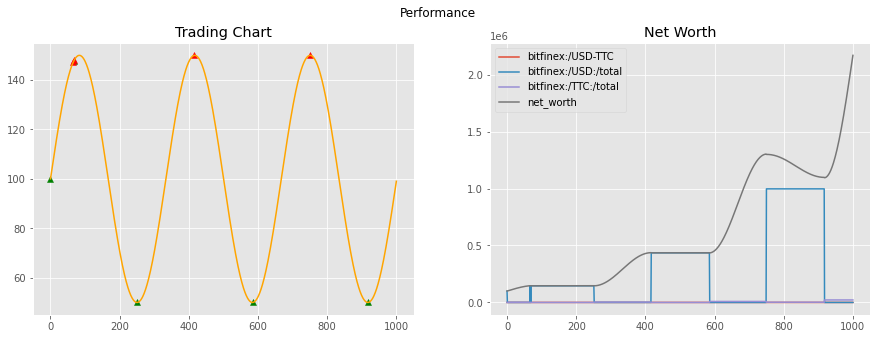

In [10]:
# Instantiate the environment
env = create_env({
    "window_size": 25
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()

In [11]:
from symfit import parameters, variables, sin, cos, Fit

def fourier_series(x, f, n=0):
    """Creates a symbolic fourier series of order `n`.

    Parameters
    ----------
    x : `symfit.Variable`
        The input variable for the function.
    f : `symfit.Parameter`
        Frequency of the fourier series
    n : int
        Order of the fourier series.
    """
    # Make the parameter objects for all the terms
    a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))

    # Construct the series
    series = a0 + sum(ai * cos(i * f * x) + bi * sin(i * f * x)
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    return series


def gbm(price: float,
        mu: float,
        sigma: float,
        dt: float,
        n: int) -> np.array:
    """Generates a geometric brownian motion path.

    Parameters
    ----------
    price : float
        The initial price of the series.
    mu : float
        The percentage drift.
    sigma : float
        The percentage volatility.
    dt : float
        The time step size.
    n : int
        The number of steps to be generated in the path.

    Returns
    -------
    `np.array`
        The generated path.
    """
    y = np.exp((mu - sigma ** 2 / 2) * dt + sigma * np.random.normal(0, np.sqrt(dt), size=n).T)
    y = price * y.cumprod(axis=0)
    return y


def fourier_gbm(price, mu, sigma, dt, n, order):

    x, y = variables('x, y')
    w, = parameters('w')
    model_dict = {y: fourier_series(x, f=w, n=order)}

    # Make step function data
    xdata = np.arange(-np.pi, np.pi, 2*np.pi / n)
    ydata = np.log(gbm(price, mu, sigma, dt, n))

    # Define a Fit object for this model and data
    fit = Fit(model_dict, x=xdata, y=ydata)
    fit_result = fit.execute()

    return np.exp(fit.model(x=xdata, **fit_result.params).y)

(pid=4014) WARNING:tensorflow:From /Users/yuan/Projects/github/ai-trading/env/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=4014) Instructions for updating:
(pid=4014) non-resource variables are not supported in the long term
(pid=4058) WARNING:tensorflow:From /Users/yuan/Projects/github/ai-trading/env/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=4058) Instructions for updating:
(pid=4058) non-resource variables are not supported in the long term
(pid=4058) 2021-05-08 18:42:54,152	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
(pid=4058) 2021-05-08 18:42:54,153	DEBUG catalog.py:470 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 

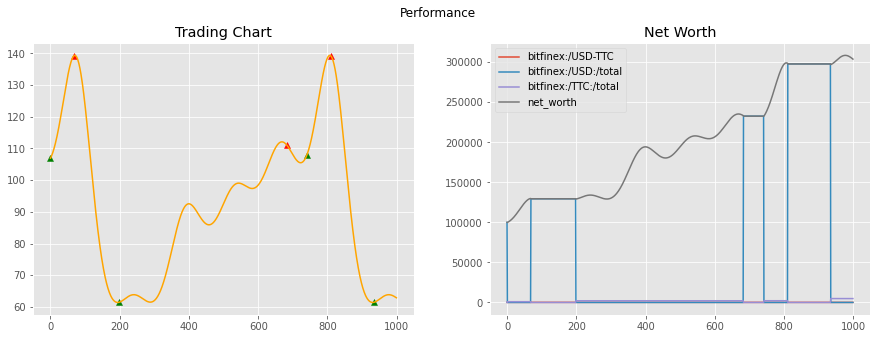

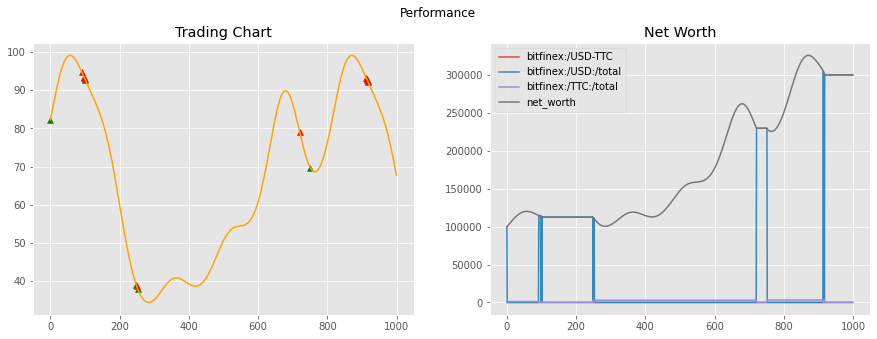

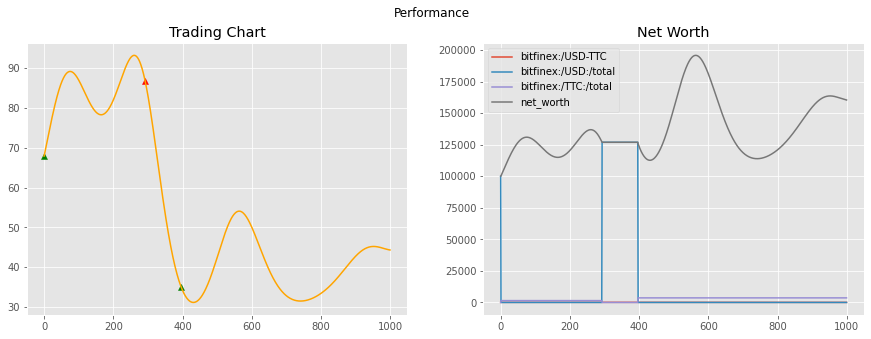

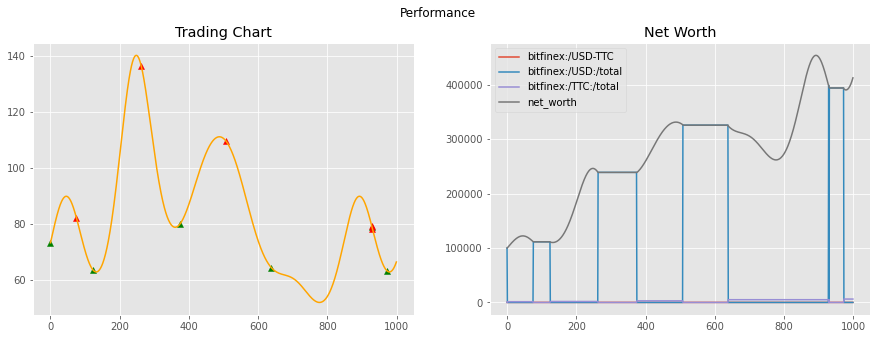

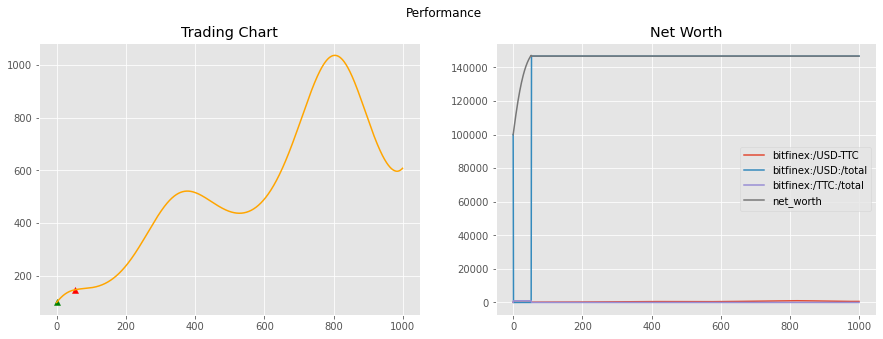

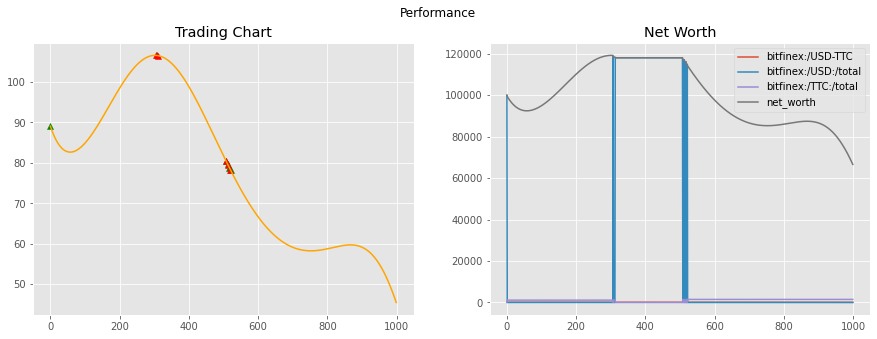

In [12]:
def create_eval_env(config):
    y = config["y"]

    x = np.arange(0, 2*np.pi, 2*np.pi / 1000)
    p = Stream.source(y, dtype="float").rename("USD-TTC")

    bitfinex = Exchange("bitfinex", service=execute_order)(
        p
    )

    cash = Wallet(bitfinex, 100000 * USD)
    asset = Wallet(bitfinex, 0 * TTC)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])

    feed = DataFeed([
        p,
        p.rolling(window=10).mean().rename("fast"),
        p.rolling(window=50).mean().rename("medium"),
        p.rolling(window=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(y, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.2
    )
    return environment

for _ in range(6):
    # Instantiate the environment
    env = create_eval_env({
        "window_size": 25,
        "y": fourier_gbm(price=100, mu=0.1, sigma=0.5, dt=0.01, n=1000, order=5)
    })


    # Run until episode ends
    episode_reward = 0
    done = False
    obs = env.reset()

    while not done:
        action = agent.compute_action(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward

    env.render()

As you can see, the agent has been able to make correct decisions on some of the price curves, but not all of them. In particular, the last three curves showcase some of the shortcomings of the agent. In samples 4 and 5, it doesn’t seem to understand that the general trend is downward, and that it should transfer all of its assets into cash. For sample 6, the agent seemed to stop making decisions altogether. This can most likely be attributed to the high volatility of the price curve, containing many local minima and maxima relative to the first three curves. With the price changing so fast, the agent decides that the best option is to hold the entire time.


### Test trained model with cryptocurrency data

In [13]:
from tensortrade.data.cdd import CryptoDataDownload
from tensortrade.oms.instruments import USD, BTC, ETH

def create_env(config, data):
    p = Stream.source(list(data["close"]), dtype="float").rename("USD-BTC")
    bitstamp = Exchange("bitstamp", service=execute_order)(
        p
    )

    cash = Wallet(bitstamp, 10000 * USD)
    asset = Wallet(bitstamp, 0.05 * BTC)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])


    feed = DataFeed([
        p,
        p.rolling(window=10).mean().rename("fast"),
        p.rolling(window=50).mean().rename("medium"),
        p.rolling(window=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(data["close"], dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.2
    )
    return environment

register_env("TradingEnv", create_env)



In [14]:
from tensortrade.data.cdd import CryptoDataDownload
from tensortrade.oms.instruments import USD, BTC, ETH

cdd = CryptoDataDownload()

data = cdd.fetch("Bitstamp", "USD", "BTC", "1h")

df = data.copy()

df.describe()

,unix,open,high,low,close,volume
count,2.613000e+04,26130.000000,26130.000000,26130.000000,26130.000000,2.613000e+04
mean,1.573399e+09,13169.790807,13244.880182,13088.633824,13171.611899,2.186515e+06
std,2.715694e+07,13755.677013,13851.609282,13652.008795,13758.337786,7.270127e+06
min,1.526364e+09,3139.760000,3158.340000,3122.280000,3139.760000,0.000000e+00
25%,1.549880e+09,6474.245000,6498.082500,6447.412500,6474.245000,1.297400e+02
50%,1.573400e+09,8642.325000,8675.310000,8603.310000,8642.325000,2.800800e+02
75%,1.596916e+09,11045.580000,11100.600000,10965.000000,11046.167500,8.860200e+02
max,1.620432e+09,64581.810000,64895.220000,64439.740000,64616.800000,2.582324e+08


{'step': 1, 'net_worth': 10404.680228730002}
{'step': 1001, 'net_worth': 10398.39}
{'step': 2001, 'net_worth': 10398.39}
{'step': 3001, 'net_worth': 10398.39}
{'step': 4001, 'net_worth': 10398.39}
{'step': 5001, 'net_worth': 10398.39}
{'step': 6001, 'net_worth': 10398.39}
{'step': 7001, 'net_worth': 10398.39}
{'step': 8001, 'net_worth': 10398.39}
{'step': 9001, 'net_worth': 10398.39}
{'step': 10001, 'net_worth': 10398.39}
{'step': 11001, 'net_worth': 10398.39}
{'step': 12001, 'net_worth': 10398.39}
{'step': 13001, 'net_worth': 10398.39}
{'step': 14001, 'net_worth': 10398.39}
{'step': 15001, 'net_worth': 10398.39}
{'step': 16001, 'net_worth': 10398.39}
{'step': 17001, 'net_worth': 10398.39}
{'step': 18001, 'net_worth': 10398.39}
{'step': 19001, 'net_worth': 10398.39}
{'step': 20001, 'net_worth': 10398.39}
{'step': 21001, 'net_worth': 10398.39}
{'step': 22001, 'net_worth': 10398.39}
{'step': 23001, 'net_worth': 10398.39}
{'step': 24001, 'net_worth': 10398.39}
{'step': 25001, 'net_worth':

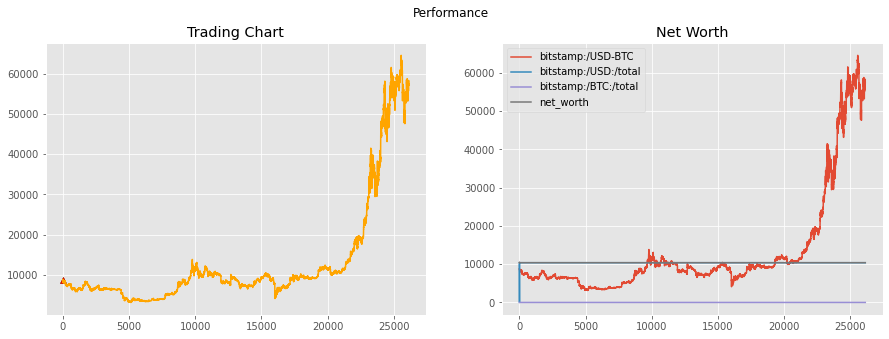

In [15]:
# Instantiate the environment
env = create_env({"window_size": 25}, df)

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

for _ in range(len(df.index)):
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    if _ % 1000 == 0: print(info) 

env.render()

In [17]:
from pandasgui import show
from datetime import datetime

today = datetime.today().strftime('%Y-%m-%d')
performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
performance.to_csv('result/BTC_USD_Sample_Model_Performance_{}.csv'.format(today))
gui = show(performance)

In [18]:
from IPython.core.display import display, HTML
from pivottablejs import pivot_ui

file_name = 'result/BTC_USD_Performance_{}.html'.format(today)
pivot_ui(performance,outfile_path=file_name)
# HTML('BTC_USD_Performance.html')
display(HTML(file_name))

In [19]:
ledger = env.action_scheme.portfolio.ledger.as_frame()
gui = show(ledger)

## Conclusion
Our main goal was to test that our reward and action scheme could be used to train an agent to make profitable decisions on a simple sine curve. Despite the suboptimal performance on some of the latter samples, the objective here was to get insight into agent decisions and inform how we engineer future reward schemes. From these basic concepts, you can work up to building more complex action and reward schemes, from which successful algorithms can be made. There is no limit to the kinds of trading environments that can be created with TensorTrade, and I encourage everybody to experiment with the different possibilities. So that about wraps up this tutorial! You can checkout the TensorTrade library to learn more on how to use it to make your own trading environments.